In [9]:
from DataLoader import *
from Data import Data
from Evalute import evaluate_model
# from Models.SimpleCF import SimpleCF
# from NeuMF import get_model
import numpy as np

In [10]:
# !pip install gast==0.2.2

In [11]:
convert_binary = True
load_model = False
testset_percentage = 0.2


print('Started...')
DATASET_NAME = 'movielens100k'
# DATASET_NAME = 'movielens1m'
df = get_from_dataset_name(DATASET_NAME, True)
data = Data(seed=42)
train_set, test_set, n_users, n_movies = data.pre_processing(df, test_percent=1)

Started...
Dataset: movielens100k , convert_binary: True
pre_processing.. 
n_real_users: 943 n_movies: 1682
train_set size (/w negative sampling): 495285 test_set: size 943


In [12]:
# n_fake_users = 300
# # possible the need to have n_movies+1
# fake_users_mat = np.zeros((n_fake_users , n_movies))
# n_users_w_fake = n_fake_users + n_users + 1

In [13]:
# import keras
# from keras.layers import Embedding, Input, Flatten
import tensorflow as tf

class Model:
    def __init__(self, num_users, num_items, mf_dim=8, layers=[64, 32, 16, 8], reg_layers=[0, 0, 0, 0], reg_mf=0):
        with tf.variable_scope('NeuCF_network'):
            self.user_inp = tf.placeholder(dtype=tf.int32, shape=[None], name='user_input')
            self.item_inp = tf.placeholder(dtype=tf.int32, shape=[None], name='item_input')
            self.y_true = tf.placeholder(dtype=tf.float32, shape=[None], name='y_true')

            normal_init = tf.random_normal_initializer(mean=0, stddev=0.01)
            pred_init = tf.keras.initializers.lecun_uniform(seed=None)
            # TODO: Add regulaizer
            
            mf_embedding_user = tf.Variable(normal_init([num_users, mf_dim]), name='mf_embedding_user')
            mf_embed_user = tf.nn.embedding_lookup(mf_embedding_user, self.user_inp)

            mf_embedding_item = tf.Variable(normal_init([num_items, mf_dim]), name='mf_embedding_item')
            mf_embed_item = tf.nn.embedding_lookup(mf_embedding_item, self.item_inp)

            mlp_embedding_user = tf.Variable(normal_init([num_users, int(layers[0] / 2)]), name='mlp_embedding_user')
            mlp_embed_user = tf.nn.embedding_lookup(mlp_embedding_user, self.user_inp)

            mlp_embedding_item = tf.Variable(normal_init([num_items, int(layers[0] / 2)]), name='mlp_embedding_item')
            mlp_embed_item = tf.nn.embedding_lookup(mlp_embedding_item, self.item_inp)
            
            # MF part
            mf_user_latent = tf.reshape(mf_embed_user, [-1, mf_embed_user.shape[-1]])
            mf_item_latent = tf.reshape(mf_embed_item, [-1, mf_embed_item.shape[-1]])
            mf_vector = tf.multiply(mf_user_latent, mf_item_latent)
            # MLP part
            mlp_user_latent = tf.reshape(mlp_embed_user, [-1, mlp_embed_user.shape[-1]])
            mlp_item_latent = tf.reshape(mlp_embed_item, [-1, mlp_embed_item.shape[-1]])
            mlp_vector = tf.concat([mlp_user_latent, mlp_item_latent], axis=-1)
            num_layer = len(layers)
            for idx in range(1, num_layer):
                mlp_vector = tf.layers.dense(mlp_vector, layers[idx], activation=tf.nn.relu, name="layer{}".format(idx))

            self.predict_vector = tf.concat([mf_vector, mlp_vector], axis =-1)
            
            prediction = tf.layers.dense(inputs=self.predict_vector,
                                              kernel_initializer = pred_init,
                                              bias_initializer = pred_init,
                                              units=1, activation='sigmoid')
            self.prediction = tf.reshape(prediction, [-1], name='prediction')
            self.loss = tf.keras.losses.binary_crossentropy(y_pred=self.prediction, y_true=self.y_true)
#             self.loss = tf.reduce_mean((self.y_true*tf.log(self.prediction)) + ((1-self.y_true)*tf.log(1-self.prediction))) # (Y_TRUE - PREDICTION)
            self.optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)
            self.train_op = self.optimizer.minimize(self.loss)

In [14]:
def get_model(n_fake_users, n_users, n_movies):
    num_users = n_fake_users + n_users
    num_items = n_movies
    batch_size = 512
    
    #model params:
    mf_dim = 8
    layers = [64, 32, 16, 8]
    reg_layers = [0, 0, 0, 0]
    reg_mf = 0

    learning_rate = 0.001
    model = Model(num_users = num_users,
                  num_items = num_items,
                  mf_dim = mf_dim,
                  layers= layers,
                  reg_layers=reg_layers,
                  reg_mf=reg_mf)
    print(f'model with: n_fake_users={n_fake_users}, n_users={n_users}, n_movies={n_movies} created')
    return model

In [15]:
class TFPredictWrapper:
    def __init__(self, model):
        self.model = model
    def predict(self, user_item, verbose):
        [u, i] = user_item
        model = self.model
        preds = sess.run(model.prediction,
                          feed_dict={model.user_inp: u,
                           model.item_inp: i})
                                            
        return preds

In [16]:
import numpy as np
N_FAKE_USERS = 8
# https://stackoverflow.com/questions/49842705/reuse-tensorflow-session-without-making-a-checkpoint

def get_batches(training_set, batch_size ):
    training_mat = np.column_stack(training_set)
    np.random.shuffle(training_mat)
    # return np.vsplit(training_mat, training_mat.shape[0] // batch_size)
    batches = np.array_split(training_mat, training_mat.shape[0] // batch_size)
    return batches
    # print(len(batches))
epochs = 10
batch_size = 512
tf.reset_default_graph()
with tf.Session() as sess:
    model = get_model(n_fake_users=N_FAKE_USERS, n_users=n_users, n_movies=n_movies)
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    model_p = TFPredictWrapper(model)
    # training and validation
    for e in range(epochs):
        batches = get_batches(train_set, batch_size = batch_size)
        loses_in_epoch = []
        for b in batches:
            u = b[:,0]
            i = b[:,1]
            r = b[:,2]
            _, preds, loss = sess.run([model.train_op, model.prediction, model.loss],
                                      feed_dict={model.user_inp: u,
                                       model.item_inp: i,
                                       model.y_true: r})
            loses_in_epoch.append(np.mean(loss))
        epoch_loss = np.mean(loses_in_epoch)

        mean_hr, mean_ndcg, time_eval = evaluate_model(model_p, test_set, verbose=0)
        print('e={} hr={:.3f} ndcg={:.3f} time={:.3f} train_loss={:.3f} '.format(e+1, mean_hr, mean_ndcg, time_eval, epoch_loss))
    save_path = saver.save(sess, "model.ckpt")

model with: n_fake_users=8, n_users=943, n_movies=1682 created
e=1 hr=0.446 ndcg=0.247 time=0.285 train_loss=0.424 
e=2 hr=0.511 ndcg=0.269 time=0.262 train_loss=0.362 
e=3 hr=0.528 ndcg=0.282 time=0.278 train_loss=0.342 
e=4 hr=0.522 ndcg=0.280 time=0.253 train_loss=0.332 
e=5 hr=0.531 ndcg=0.281 time=0.244 train_loss=0.326 
e=6 hr=0.541 ndcg=0.289 time=0.248 train_loss=0.320 
e=7 hr=0.537 ndcg=0.283 time=0.263 train_loss=0.316 
e=8 hr=0.542 ndcg=0.285 time=0.250 train_loss=0.311 
e=9 hr=0.537 ndcg=0.280 time=0.327 train_loss=0.307 
e=10 hr=0.530 ndcg=0.280 time=0.285 train_loss=0.303 


In [17]:
tf.reset_default_graph()
with tf.Session() as sess:
    model = get_model(n_fake_users=N_FAKE_USERS, n_users=n_users, n_movies=n_movies)
    saver = tf.train.Saver()
    saver.restore(sess, "model.ckpt")
    model_p = TFPredictWrapper(model)
    mean_hr, mean_ndcg, time_eval = evaluate_model(model_p, test_set, verbose=0)
    print('e={} hr={:.3f} ndcg={:.3f} time={:.3f}'.format(e+1, mean_hr, mean_ndcg, time_eval))
#     preds = model.sess.run(model.prediction,
#                               feed_dict={model.user_inp: users,
#                                model.item_inp: items})

model with: n_fake_users=8, n_users=943, n_movies=1682 created
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from model.ckpt
e=10 hr=0.530 ndcg=0.280 time=0.271


In [56]:
# mal_train_set = [users + train_set[0], items + train_set[1]]
output_dim = (N_FAKE_USERS-1) * (n_movies-1)
fake_ratings = np.full((output_dim,), 2)
cartesian_prodcut = np.array([[n_users + user - 1, item] 
                              for user in np.arange(1, N_FAKE_USERS) for item in np.arange(1, n_movies)])
attack_users = cartesian_prodcut[:, 0]
attack_items = cartesian_prodcut[:, 1]
# np.append(fake_ratings, train_set[2])
attack_train_set = np.array([np.append(attack_users, train_set[0]),
                          np.append(attack_items, train_set[1])])
real_training_rating_size = len(train_set[2])
print('attack rating size=', output_dim)
print('real_training_rating_size=', real_training_rating_size)

attack rating size= 11767
real_training_rating_size= 495285


In [57]:
output_dim = (N_FAKE_USERS-1) * (n_movies-1)
tf.reset_default_graph()
mal_real_shape = output_dim + real_training_rating_size
rating_input = tf.placeholder(tf.float32, [mal_real_shape], name='benzona')
model = get_model(n_fake_users=N_FAKE_USERS, n_users=n_users, n_movies=n_movies)
print(rating_input.shape)
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, "model.ckpt")
    eps_p = tf.placeholder(tf.float32, mal_real_shape)
    mask_p = tf.placeholder(tf.float32, mal_real_shape)
#     prediction = tf.layers.dense(inputs=model.predict_vector,units=1, activation='sigmoid')
#     prediction = tf.reshape(prediction, [-1], name='prediction')
    new_loss = tf.keras.losses.binary_crossentropy(y_pred=model.prediction, y_true=rating_input)
    grad = tf.gradients(new_loss, rating_input) # take the gradient of the loss according to prediction # check
    # new_labels_op = tf.stop_gradient(rating_input + epsilon * tf.sign(grad)) # perform a gradient step
#     rating_input_out = tf.stop_gradient(rating_input + (eps_p * tf.sign(grad) * mask_p)) # perform a gradient step
    rating_input_out = tf.stop_gradient(rating_input + (eps_p * grad * mask_p)) # perform a gradient step
    rating_input_out = tf.reshape(tf.clip_by_value(rating_input_out, 0, 1), (-1,))
    step = 1000
    eps = np.full((mal_real_shape,), step)
#     y_true = np.random.randint(0, 2, (output_dim,)) ### WHATT IS THIS?
    # try to emulate a session with all data - training_set + adver, then the gradient will adjust adver rating params
#     new_labels = np.full((output_dim,), 0.01) # initiate new ratings at 0.5
    new_labels_mal_part = np.full((output_dim,), 0.5)
    new_labels = np.concatenate([new_labels_mal_part, train_set[2]])
    all_users = mal_train_set[0]
    all_items = mal_train_set[1]
    indexes = np.arange(len(all_users))
#new_labels.shape
    for i in range(20):
        ## Todo: There is an issue in creating a shuffle while keeping track in the order of the mal data
#         print(i)
#         p = np.random.permutation(len(new_labels))
#         all_users = all_users[p]
#         all_items = all_items[p]
#         new_labels = new_labels[p]
#         new_labels_before_change = new_labels.copy()
        mask = np.zeros((mal_real_shape,))
#         indexes = indexes[p] # this will help get the mal ratings in order as we started
        mask[np.argwhere(indexes < output_dim)] = 1
        
        new_labels, adv_l= sess.run([rating_input_out, new_loss],
                                 feed_dict={model.user_inp: all_users,
                                            model.item_inp: all_items,
                                            rating_input: new_labels,
                                            mask_p: mask,
                                            eps_p: eps})
        new_labels = new_labels.reshape((-1,))
#         new_labels[np.argwhere(indexes >= output_dim)] = new_labels_before_change[np.argwhere(indexes >= output_dim)]
        attack_rating = new_labels[np.argwhere(indexes < output_dim)][np.arange(output_dim)].reshape(-1,)
        ## Safety Check such that legit ratings did not change
        legit_rating = new_labels[np.argwhere(indexes > output_dim)].reshape(-1,)
        assert len(np.unique(legit_rating)) ==2, 'legit rating must not change during gradient step'
        print(i, np.round(attack_rating[:10], 2), np.mean(mal_only))
#         print('adv_l={:0.4f}, max={:.4f} min={:.4f} count={}'.format(adv_l, np.max(mal_only), np.min(mal_only), len(np.unique(mal_only))))
#         new_labels_before_change[]

model with: n_fake_users=8, n_users=943, n_movies=1682 created
(507052,)
INFO:tensorflow:Restoring parameters from model.ckpt
0 [0.5  0.51 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5 ] 0.634248
1 [0.5  0.52 0.51 0.5  0.5  0.5  0.51 0.51 0.5  0.5 ] 0.634248
2 [0.5  0.53 0.51 0.51 0.51 0.5  0.51 0.51 0.5  0.5 ] 0.634248
3 [0.5  0.54 0.52 0.51 0.51 0.5  0.52 0.51 0.5  0.5 ] 0.634248
4 [0.5  0.55 0.52 0.51 0.51 0.5  0.52 0.51 0.51 0.5 ] 0.634248
5 [0.5  0.56 0.53 0.51 0.51 0.5  0.53 0.52 0.51 0.5 ] 0.634248
6 [0.5  0.57 0.53 0.52 0.51 0.5  0.53 0.52 0.51 0.5 ] 0.634248
7 [0.5  0.58 0.54 0.52 0.52 0.5  0.54 0.52 0.51 0.5 ] 0.634248
8 [0.5  0.59 0.54 0.52 0.52 0.5  0.54 0.52 0.51 0.5 ] 0.634248
9 [0.5  0.6  0.55 0.52 0.52 0.5  0.54 0.53 0.51 0.5 ] 0.634248
10 [0.5  0.61 0.55 0.53 0.52 0.5  0.55 0.53 0.51 0.5 ] 0.634248
11 [0.5  0.62 0.55 0.53 0.52 0.5  0.55 0.53 0.51 0.5 ] 0.634248
12 [0.5  0.63 0.56 0.53 0.52 0.5  0.56 0.53 0.51 0.5 ] 0.634248
13 [0.5  0.64 0.56 0.53 0.53 0.5  0.56 0.54 0.52 0.5

In [54]:
new_labels

array([0.5052762, 0.7008748, 0.5914347, ..., 0.       , 0.       ,
       0.       ], dtype=float32)

In [58]:
assert len(attack_users) == len(attack_items)
assert len(attack_users) == len(attack_rating)

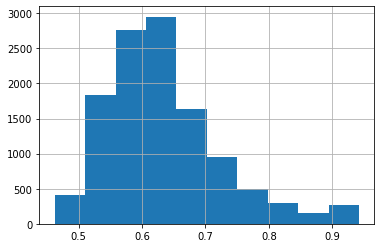

In [60]:
# for each user, we want to keep all positive ones, and keep excatly positive_ones* 4 zeros.
import pandas as pd
base_attack_df = pd.DataFrame({'u': attack_users, 'i':attack_items, 'r_per': attack_rating})
# maybe its better to take top ## instead of rint
base_attack_df.r.hist(bins=10)

In [64]:
# df[:].groupby('u').apply(lambda x: print(x))
treshold = 0.90
attack_df_filterd = base_attack_df[base_attack_df.apply(lambda x: x.r > treshold, axis=1)] # apply on rows, keep only high prob ratings
attack_df_filterd['r'] = attack_df_filterd['r'].apply(lambda x: 1) #|.astype(int)
attack_df_filterd

/Users/lidora/opt/anaconda3/envs/ars/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,u,i,r
870,943,871,1
1334,943,1335,1
1341,943,1342,1
1367,943,1368,1
1392,943,1393,1
...,...,...,...
11740,949,1655,1
11742,949,1657,1
11748,949,1663,1
11749,949,1664,1


In [66]:
## add negative sampling to the mal data frame
from tqdm import tqdm
df = attack_df_filterd
negative_items = {}
users = list(sorted(df['u'].unique()))
for idx, user in tqdm(enumerate(users), total=len(users)):
    negative_items[user] = df[df['u'] != user]['i'].unique()
negative_items
num_negatives = 4
df = df.groupby('u').apply(lambda s: s.sample(frac=1))
user_input, item_input, labels = [], [], []
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    user = row['u']
    user_input.append(user)
    item_input.append(row['i'])
    labels.append(row['r'])
    negative_input_items = np.random.choice(negative_items[user], num_negatives)
    for neg_item in negative_input_items:
        user_input.append(user)
        item_input.append(neg_item)
        labels.append(0)

mal_training_set = (np.array(user_input), np.array(item_input), np.array(labels))
mal_training_set # this already has the inputs and negative items


100%|██████████| 230/230 [00:00<00:00, 6818.27it/s]


(array([943, 943, 943, ..., 949, 949, 949]),
 array([1545, 1484, 1545, ..., 1431, 1420, 1396]),
 array([1, 0, 0, ..., 0, 0, 0]))

In [69]:
from Data import create_subset, concat_and_shuffle
TRAIN_FRAC = 0.10
malicious_training_set = mal_training_set
# malicious_training_set = (df_filterd.values[:,0], df_filterd.values[:,1], df_filterd.values[:,2])
print('df_filterd', len(df_filterd))
print('train_set',len(train_set[0]))
train_set_subset = create_subset(train_set, train_frac=TRAIN_FRAC)
attack_benign_training_set = concat_and_shuffle(malicious_training_set, train_set_subset)
print(len(malicious_training_set[0]))
len(attack_benign_training_set[0])

df_filterd 7188
train_set 495285
1150


50678

In [70]:
# evaluate the model using the fake predictions
tf.reset_default_graph()
model = get_model(n_fake_users=N_FAKE_USERS, n_users=n_users, n_movies=n_movies)
model_p = TFPredictWrapper(model)
mal_epochs = 5
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, "model.ckpt")
    for e in range(mal_epochs):
        batches = get_batches(attack_benign_training_set, batch_size = batch_size)
        u = attack_benign_training_set[0]
        i = attack_benign_training_set[1]
        r = attack_benign_training_set[2]
        _, preds, loss = sess.run([model.train_op, model.prediction, model.loss],
                                  feed_dict={model.user_inp: u,
                                   model.item_inp: i,
                                   model.y_true: r})
            
        epoch_loss = np.mean(loses_in_epoch)
        mean_hr, mean_ndcg, time_eval = evaluate_model(model_p, test_set, verbose=0)
        print('{:.3f} {:.3f} {:.3f} {:.3f}'.format(epoch_loss, mean_hr, mean_ndcg, time_eval))

model with: n_fake_users=8, n_users=943, n_movies=1682 created
INFO:tensorflow:Restoring parameters from model.ckpt
0.303 0.529 0.280 0.271
0.303 0.528 0.279 0.243
0.303 0.527 0.278 0.245
0.303 0.522 0.277 0.247
0.303 0.522 0.277 0.246


In [83]:
# evaluate the model using the fake predictions
tf.reset_default_graph()
model = get_model(n_fake_users=N_FAKE_USERS, n_users=n_users, n_movies=n_movies)

with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, "model.ckpt")
    model_p = TFPredictWrapper(model)
    for e in range(mal_epochs):
        batches = get_batches(attack_benign_training_set, batch_size = batch_size)
        loses_in_epoch = []
        for b in batches:
            u = b[:,0]
            i = b[:,1]
            r = b[:,2]
            _, preds, loss = sess.run([model.train_op, model.prediction, model.loss],
                                      feed_dict={model.user_inp: u,
                                       model.item_inp: i,
                                       model.y_true: r})
            loses_in_epoch.append(np.mean(loss))
        epoch_loss = np.mean(loses_in_epoch)
        mean_hr, mean_ndcg, time_eval = evaluate_model(model_p, test_set, verbose=0)
        print('{:.3f} {:.3f} {:.3f} {:.3f}'.format(epoch_loss, mean_hr, mean_ndcg, time_eval))

model with: n_fake_users=64, n_users=943, n_movies=1682 created
INFO:tensorflow:Restoring parameters from model.ckpt
0.491 0.552 0.283 0.301
0.483 0.540 0.281 0.235
0.481 0.534 0.275 0.232
0.479 0.524 0.270 0.242
0.476 0.493 0.258 0.240


In [ ]:
# with model.sess:
new_inp.eval()

In [ ]:
np.arange(1, n_fake_users)

In [ ]:
"""FGSM ATTACK"""

# user_inp = tf.placeholder(tf.float32, (n_fake_users, 64))
# item_inp = tf.placeholder(tf.float32, (n_movies, 64))
# # true_out = tf.placeholder(tf.float32, (n_fake_users, 10))
epsilon = tf.placeholder(tf.float32, [n_fake_users * n_movies])
# user_inp = tf.Variable((n_fake_users, 64), tf.float32)
# item_inp = tf.Variable((n_fake_users, 64), tf.float32)
# # true_out = tf.placeholder(tf.float32, (n_fake_users, 10))
# epsilon = tf.Variable([n_fake_users, 64], tf.float32)

In [ ]:
with tf.Session() as sess:
    mean_hr, mean_ndcg, time_eval = evaluate_model(model_p, test_set, verbose=0)
    preds = sess.run(model.prediction,
                              feed_dict={model.user_inp: users,
                               model.item_inp: items})
    grad = tf.gradients(model.loss, [self.rating_input])
# grad
# grad1 = tf.gradients(loss, new_inp)
# grad = tf.where(tf.is_nan(grad1), tf.zeros_like(grad1)*1, grad1) #replace nans with zeros
# new_inp = tf.stop_gradient(data + epsilon * tf.sign(grad))
# new_inp

In [ ]:
"""FGSM ATTACK"""

n_adversarial = y_test.shape[0]

trgt_inp = tf.placeholder(tf.float32, (n_fake_users, 64))
# true_out = tf.placeholder(tf.float32, (n_fake_users, 10))
epsilon = tf.placeholder(tf.float32, [n_adversarial, img_width, img_height, 1])

new_inp = tf.identity(trgt_inp)  #returns a tensor with the same shape and type

output = model(new_inp)

loss = tf.sqrt(tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=true_out))

grad = tf.gradients(loss, new_inp)
new_inp = tf.stop_gradient(new_inp + epsilon * tf.sign(grad))

step = 0.1
eps = np.full((n_adversarial, img_width, img_height, 1), step)

feed_dict = {trgt_inp: x_test,
             true_out: y_test,
             epsilon: eps}

x_adv, l = sess.run([new_inp, loss],
                    feed_dict)

x_adv = x_adv.reshape((n_adversarial, img_width, img_height, 1))

acc_bfr_attck = model.evaluate(x=x_test, y=y_test, batch_size=32)[1]
acc_aftr_attck = model.evaluate(x=x_adv, y=y_test, batch_size=32)[1]
print('Accuracy before FGSM {}, Accuracy after FGSM {}'.format(acc_bfr_attck, acc_aftr_attck))

In [ ]:
x = [[2.]]
m = tf.matmul(x, x)
print("hello, {}".format(m))


In [16]:
t = np.zeros((10,))
indexes = [1, 3, 5 ,7]
t[indexes] = 1

In [21]:
t[indexes] = not t[indexes].all
t

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [36]:
p = 0.000000000009
-(1*np.log(p) + 0 * np.log(1-p))

25.43379653859233